In [7]:
import os
import pandas as pd

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_04_25_AppSci_AODV_V02"
modes = ["L", "P"]
density = "D400"
speed = "S20"
nodes = [0, 9, 17, 22, 29]

log_files = [
    "sendPing.txt",
    "success_app.txt",
    "rreqCount.txt",
    "rrepCount.txt",
    "collision_log.txt",
    "sinr_drop_log.csv",
    "recovery_log.csv",
    "aodv_routing_log.csv"
]

def filter_log_by_time(filepath, start_time=30.0, end_time=99.0, time_col_idx=0, sep=","):
    if not os.path.isfile(filepath):
        return []
    filtered = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split(sep)
            try:
                timestamp = float(parts[time_col_idx])
                if start_time <= timestamp <= end_time:
                    filtered.append(line.strip())
            except:
                continue
    return filtered

results = []

for node in nodes:
    node_dir = f"N{node}"
    for log_file in log_files:
        sep = "," if log_file.endswith(".csv") else ":"
        for mode in modes:
            mode_path = os.path.join(base_path, mode, density, speed, node_dir, log_file)
            data = filter_log_by_time(mode_path, sep=sep)
            results.append({
                "Node": node,
                "Log_File": log_file,
                "Mode": mode,
                "Count": len(data)
            })

df = pd.DataFrame(results)
df_pivot = df.pivot_table(index=["Node", "Log_File"], columns="Mode", values="Count", fill_value=0).reset_index()
df_pivot["Diff(P-L)"] = df_pivot["P"] - df_pivot["L"]

print(df_pivot)


Mode  Node              Log_File         L         P  Diff(P-L)
0        0  aodv_routing_log.csv  275706.0  232123.0   -43583.0
1        0     collision_log.txt       0.0       0.0        0.0
2        0      recovery_log.csv    1096.0    1237.0      141.0
3        0         rrepCount.txt       0.0       0.0        0.0
4        0         rreqCount.txt       0.0       0.0        0.0
5        0          sendPing.txt     691.0     691.0        0.0
6        0     sinr_drop_log.csv  115844.0  103636.0   -12208.0
7        0       success_app.txt     311.0     421.0      110.0
8        9  aodv_routing_log.csv  270477.0  313159.0    42682.0
9        9     collision_log.txt       0.0       0.0        0.0
10       9      recovery_log.csv    1688.0    3449.0     1761.0
11       9         rrepCount.txt       0.0       0.0        0.0
12       9         rreqCount.txt       0.0       0.0        0.0
13       9          sendPing.txt     691.0     691.0        0.0
14       9     sinr_drop_log.csv   80125

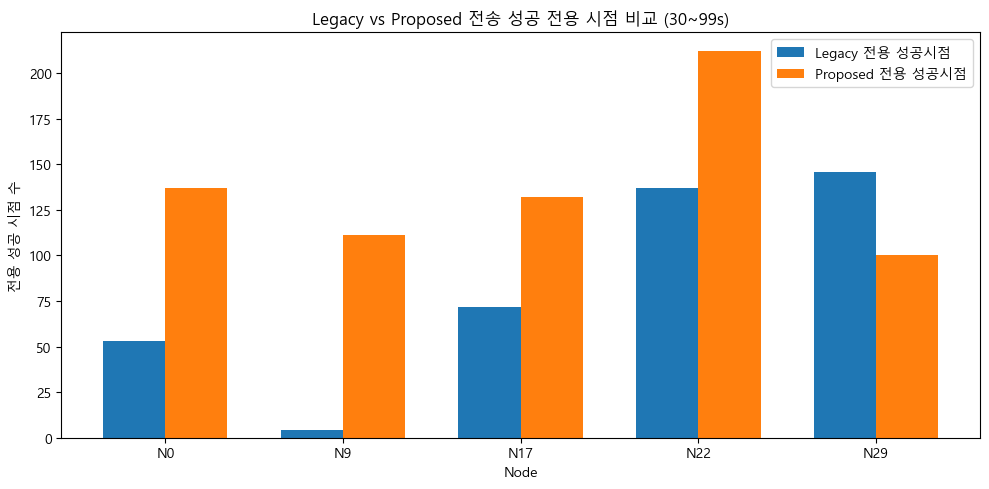

In [12]:
import os
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_04_25_AppSci_AODV_V02"
modes = ["L", "P"]
density = "D400"
speed = "S20"
nodes = [0, 9, 17, 22, 29]

def extract_times(path, sep=":", start=30.0, end=99.0):
    send_set, success_set = set(), set()
    send_file = os.path.join(path, "sendPing.txt")
    succ_file = os.path.join(path, "success_app.txt")

    if os.path.isfile(send_file):
        with open(send_file) as f:
            for line in f:
                try:
                    t = float(line.split(sep)[0])
                    if start <= t <= end:
                        send_set.add(round(t, 1))
                except: pass
    if os.path.isfile(succ_file):
        with open(succ_file) as f:
            for line in f:
                try:
                    t = float(line.split(sep)[0])
                    if start <= t <= end:
                        success_set.add(round(t, 1))
                except: pass
    return send_set, success_set

legacy_success = []
proposed_success = []
labels = []

for node in nodes:
    n = f"N{node}"
    l_path = os.path.join(base_path, "L", density, speed, n)
    p_path = os.path.join(base_path, "P", density, speed, n)

    l_send, l_succ = extract_times(l_path)
    p_send, p_succ = extract_times(p_path)

    improved = p_succ - l_succ
    missed = l_succ - p_succ

    legacy_success.append(len(missed))
    proposed_success.append(len(improved))
    labels.append(n)

x = range(len(labels))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar([i - width/2 for i in x], legacy_success, width, label="Legacy 전용 성공시점")
plt.bar([i + width/2 for i in x], proposed_success, width, label="Proposed 전용 성공시점")
plt.xticks(x, labels)
plt.xlabel("Node")
plt.ylabel("전용 성공 시점 수")
plt.title("Legacy vs Proposed 전송 성공 전용 시점 비교 (30~99s)")
plt.legend()
plt.tight_layout()
plt.show()


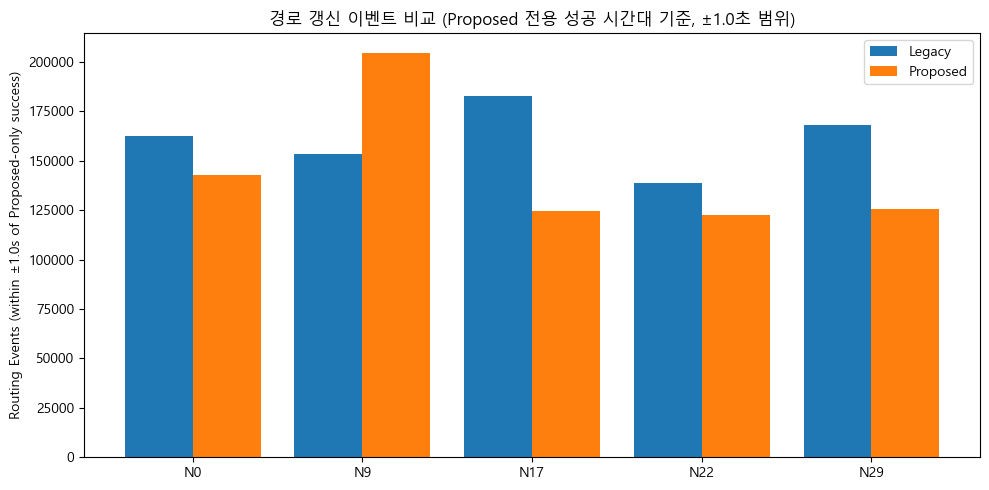

In [15]:
import os
import matplotlib.pyplot as plt
import pandas as pd

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_04_25_AppSci_AODV_V02"
density = "D400"
speed = "S20"
nodes = [0, 9, 17, 22, 29]
time_range = (30.0, 99.0)

def extract_success_times(folder):
    times = set()
    f_path = os.path.join(folder, "success_app.txt")
    if not os.path.isfile(f_path):
        return times
    with open(f_path) as f:
        for line in f:
            try:
                t = float(line.split(":")[0])
                if time_range[0] <= t <= time_range[1]:
                    times.add(round(t, 1))
            except: continue
    return times

def filter_log_by_time(filepath, times, sep=",", time_col_idx=0, delta=1.0):
    result = []
    if not os.path.isfile(filepath):
        return result
    with open(filepath) as f:
        for line in f:
            parts = line.strip().split(sep)
            try:
                t = float(parts[time_col_idx])
                for ref in times:
                    if abs(t - ref) <= delta:
                        result.append(t)
                        break
            except: continue
    return result

records = []
for node in nodes:
    node_str = f"N{node}"
    p_path = os.path.join(base_path, "P", density, speed, node_str)
    l_path = os.path.join(base_path, "L", density, speed, node_str)

    p_succ = extract_success_times(p_path)
    l_succ = extract_success_times(l_path)
    p_only = p_succ - l_succ

    r_log_p = os.path.join(p_path, "aodv_routing_log.csv")
    r_log_l = os.path.join(l_path, "aodv_routing_log.csv")

    r_p = filter_log_by_time(r_log_p, p_only, sep=",", delta=1.0)
    r_l = filter_log_by_time(r_log_l, p_only, sep=",", delta=1.0)

    records.append({
        "Node": f"N{node}",
        "Proposed_Routing": len(r_p),
        "Legacy_Routing": len(r_l)
    })

df = pd.DataFrame(records)
x = range(len(df))
plt.figure(figsize=(10, 5))
plt.bar([i - 0.2 for i in x], df["Legacy_Routing"], width=0.4, label="Legacy")
plt.bar([i + 0.2 for i in x], df["Proposed_Routing"], width=0.4, label="Proposed")
plt.xticks(x, df["Node"])
plt.ylabel("Routing Events (within ±1.0s of Proposed-only success)")
plt.title("경로 갱신 이벤트 비교 (Proposed 전용 성공 시간대 기준, ±1.0초 범위)")
plt.legend()
plt.tight_layout()
plt.show()


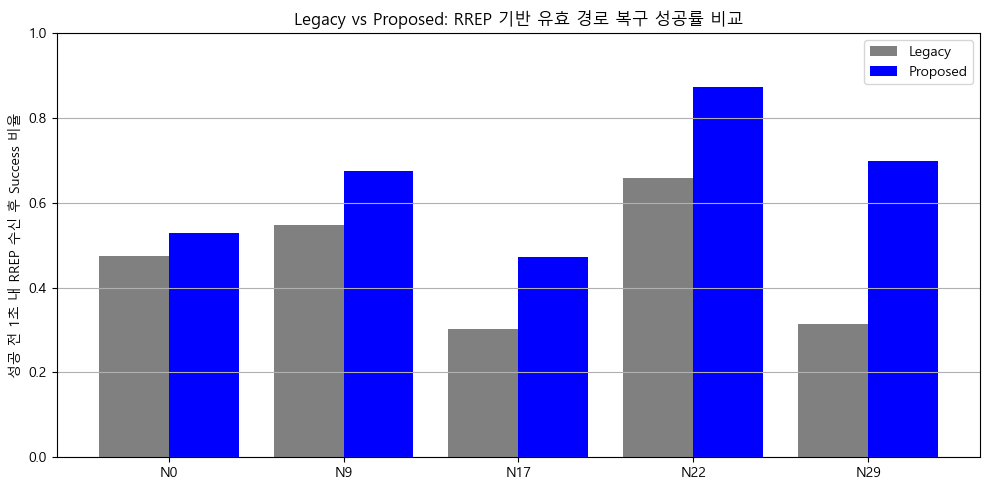

In [23]:
import os
import matplotlib.pyplot as plt
import pandas as pd

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_04_25_AppSci_AODV_V02"
density = "D400"
speed = "S20"
nodes = ["N0", "N9", "N17", "N22", "N29"]
time_range = (30.0, 99.0)
delta = 1.0

def extract_event_times(filepath, sep=":", col=0):
    times = []
    if not os.path.isfile(filepath): return times
    with open(filepath) as f:
        for line in f:
            try:
                t = float(line.strip().split(sep)[col])
                if time_range[0] <= t <= time_range[1]:
                    times.append(round(t, 3))
            except: continue
    return times

def compute_rrep_to_success_ratio(base_dir):
    ratio_data = []
    for node in nodes:
        path = os.path.join(base_dir, node)
        success_times = extract_event_times(os.path.join(path, "success_app.txt"), sep=":", col=0)
        rrep_times = []

        rec_file = os.path.join(path, "recovery_log.csv")
        if os.path.isfile(rec_file):
            with open(rec_file) as f:
                for line in f:
                    parts = line.strip().split(",")
                    try:
                        t = float(parts[0])
                        event = parts[-1]
                        if time_range[0] <= t <= time_range[1] and event == "RREP_RECV":
                            rrep_times.append(t)
                    except: continue

        matched = 0
        for r in rrep_times:
            if any(0 < s - r <= delta for s in success_times):
                matched += 1

        ratio = matched / len(rrep_times) if rrep_times else 0
        ratio_data.append({"Node": node, "RREP_Count": len(rrep_times), "Matched_Success": matched, "Ratio": round(ratio, 3)})
    return pd.DataFrame(ratio_data)

proposed_df = compute_rrep_to_success_ratio(os.path.join(base_path, "P", density, speed))
legacy_df = compute_rrep_to_success_ratio(os.path.join(base_path, "L", density, speed))

merged = proposed_df[["Node", "Ratio"]].rename(columns={"Ratio": "Proposed_Ratio"})
merged["Legacy_Ratio"] = legacy_df["Ratio"]

x = range(len(merged))
labels = merged["Node"]

plt.figure(figsize=(10, 5))
plt.bar([i - 0.2 for i in x], merged["Legacy_Ratio"], width=0.4, label="Legacy", color="gray")
plt.bar([i + 0.2 for i in x], merged["Proposed_Ratio"], width=0.4, label="Proposed", color="blue")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel("성공 전 1초 내 RREP 수신 후 Success 비율")
plt.title("Legacy vs Proposed: RREP 기반 유효 경로 복구 성공률 비교")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


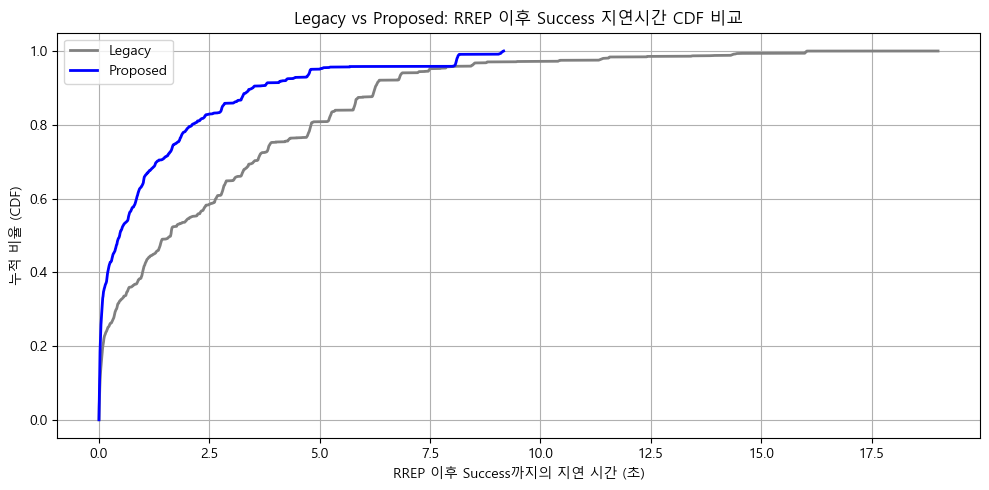

In [25]:
import os
import matplotlib.pyplot as plt
import numpy as np

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_04_25_AppSci_AODV_V02"
density = "D400"
speed = "S20"
nodes = ["N0", "N9", "N17", "N22", "N29"]
time_range = (30.0, 99.0)

def extract_event_times(filepath, sep=":", col=0):
    times = []
    if not os.path.isfile(filepath): return times
    with open(filepath) as f:
        for line in f:
            try:
                t = float(line.strip().split(sep)[col])
                if time_range[0] <= t <= time_range[1]:
                    times.append(t)
            except: continue
    return sorted(times)

def collect_delay_deltas(base_dir):
    deltas = []
    for node in nodes:
        node_path = os.path.join(base_dir, node)
        success_times = extract_event_times(os.path.join(node_path, "success_app.txt"), sep=":", col=0)
        rrep_times = []

        rec_file = os.path.join(node_path, "recovery_log.csv")
        if os.path.isfile(rec_file):
            with open(rec_file) as f:
                for line in f:
                    parts = line.strip().split(",")
                    try:
                        t = float(parts[0])
                        event = parts[-1]
                        if time_range[0] <= t <= time_range[1] and event == "RREP_RECV":
                            rrep_times.append(t)
                    except: continue

        for r in rrep_times:
            after_success = [s for s in success_times if s > r]
            if after_success:
                delta = after_success[0] - r
                deltas.append(delta)
    return np.array(deltas)

proposed_deltas = collect_delay_deltas(os.path.join(base_path, "P", density, speed))
legacy_deltas = collect_delay_deltas(os.path.join(base_path, "L", density, speed))

def compute_cdf(values):
    values = np.sort(values)
    cdf = np.arange(1, len(values) + 1) / len(values)
    return values, cdf

x_p, y_p = compute_cdf(proposed_deltas)
x_l, y_l = compute_cdf(legacy_deltas)

plt.figure(figsize=(10, 5))
plt.plot(x_l, y_l, label="Legacy", color="gray", linewidth=2)
plt.plot(x_p, y_p, label="Proposed", color="blue", linewidth=2)
plt.xlabel("RREP 이후 Success까지의 지연 시간 (초)")
plt.ylabel("누적 비율 (CDF)")
plt.title("Legacy vs Proposed: RREP 이후 Success 지연시간 CDF 비교")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


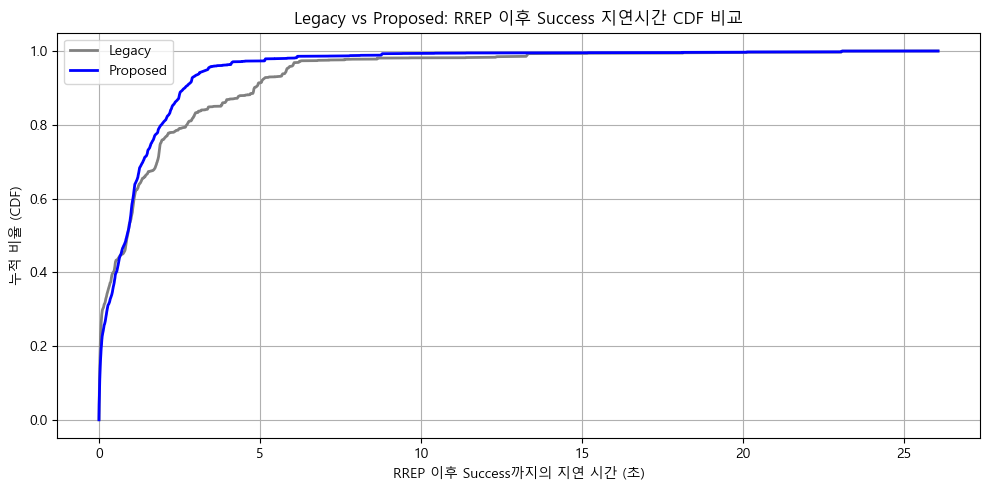

In [26]:
import os
import matplotlib.pyplot as plt
import numpy as np

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_04_25_AppSci_AODV_V02"
density = "D400"
speed = "S30"
nodes = ["N0","N4", "N6", "N9", "N10", "N11", "N17", "N22", "N29"]
time_range = (30.0, 99.0)

def extract_event_times(filepath, sep=":", col=0):
    times = []
    if not os.path.isfile(filepath): return times
    with open(filepath) as f:
        for line in f:
            try:
                t = float(line.strip().split(sep)[col])
                if time_range[0] <= t <= time_range[1]:
                    times.append(t)
            except: continue
    return sorted(times)

def collect_delay_deltas(base_dir):
    deltas = []
    for node in nodes:
        node_path = os.path.join(base_dir, node)
        success_times = extract_event_times(os.path.join(node_path, "success_app.txt"), sep=":", col=0)
        rrep_times = []

        rec_file = os.path.join(node_path, "recovery_log.csv")
        if os.path.isfile(rec_file):
            with open(rec_file) as f:
                for line in f:
                    parts = line.strip().split(",")
                    try:
                        t = float(parts[0])
                        event = parts[-1]
                        if time_range[0] <= t <= time_range[1] and event == "RREP_RECV":
                            rrep_times.append(t)
                    except: continue

        for r in rrep_times:
            after_success = [s for s in success_times if s > r]
            if after_success:
                delta = after_success[0] - r
                deltas.append(delta)
    return np.array(deltas)

proposed_deltas = collect_delay_deltas(os.path.join(base_path, "P", density, speed))
legacy_deltas = collect_delay_deltas(os.path.join(base_path, "L", density, speed))

def compute_cdf(values):
    values = np.sort(values)
    cdf = np.arange(1, len(values) + 1) / len(values)
    return values, cdf

x_p, y_p = compute_cdf(proposed_deltas)
x_l, y_l = compute_cdf(legacy_deltas)

plt.figure(figsize=(10, 5))
plt.plot(x_l, y_l, label="Legacy", color="gray", linewidth=2)
plt.plot(x_p, y_p, label="Proposed", color="blue", linewidth=2)
plt.xlabel("RREP 이후 Success까지의 지연 시간 (초)")
plt.ylabel("누적 비율 (CDF)")
plt.title("Legacy vs Proposed: RREP 이후 Success 지연시간 CDF 비교")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


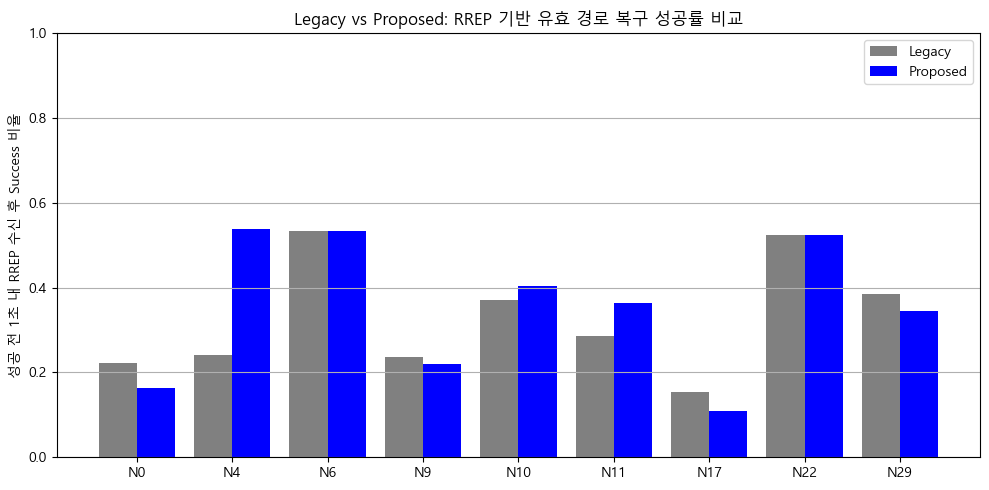

In [24]:
import os
import matplotlib.pyplot as plt
import pandas as pd

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/2025_04_25_AppSci_AODV_V02"
density = "D400"
speed = "S30"
nodes = ["N0","N4", "N6", "N9", "N10", "N11", "N17", "N22", "N29"]
time_range = (30.0, 99.0)
delta = 0.1

def extract_event_times(filepath, sep=":", col=0):
    times = []
    if not os.path.isfile(filepath): return times
    with open(filepath) as f:
        for line in f:
            try:
                t = float(line.strip().split(sep)[col])
                if time_range[0] <= t <= time_range[1]:
                    times.append(round(t, 3))
            except: continue
    return times

def compute_rrep_to_success_ratio(base_dir):
    ratio_data = []
    for node in nodes:
        path = os.path.join(base_dir, node)
        success_times = extract_event_times(os.path.join(path, "success_app.txt"), sep=":", col=0)
        rrep_times = []

        rec_file = os.path.join(path, "recovery_log.csv")
        if os.path.isfile(rec_file):
            with open(rec_file) as f:
                for line in f:
                    parts = line.strip().split(",")
                    try:
                        t = float(parts[0])
                        event = parts[-1]
                        if time_range[0] <= t <= time_range[1] and event == "RREP_RECV":
                            rrep_times.append(t)
                    except: continue

        matched = 0
        for r in rrep_times:
            if any(0 < s - r <= delta for s in success_times):
                matched += 1

        ratio = matched / len(rrep_times) if rrep_times else 0
        ratio_data.append({"Node": node, "RREP_Count": len(rrep_times), "Matched_Success": matched, "Ratio": round(ratio, 3)})
    return pd.DataFrame(ratio_data)

proposed_df = compute_rrep_to_success_ratio(os.path.join(base_path, "P", density, speed))
legacy_df = compute_rrep_to_success_ratio(os.path.join(base_path, "L", density, speed))

merged = proposed_df[["Node", "Ratio"]].rename(columns={"Ratio": "Proposed_Ratio"})
merged["Legacy_Ratio"] = legacy_df["Ratio"]

x = range(len(merged))
labels = merged["Node"]

plt.figure(figsize=(10, 5))
plt.bar([i - 0.2 for i in x], merged["Legacy_Ratio"], width=0.4, label="Legacy", color="gray")
plt.bar([i + 0.2 for i in x], merged["Proposed_Ratio"], width=0.4, label="Proposed", color="blue")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel("성공 전 1초 내 RREP 수신 후 Success 비율")
plt.title("Legacy vs Proposed: RREP 기반 유효 경로 복구 성공률 비교")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
